# 02 - Syllable Duration Entropy: Mature vs. Juvenile

## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import avn.dataloading as dataloading
import avn.segmentation
import avn.syntax as syntax
import matplotlib.pyplot as plt
from scipy.stats import entropy
import glob

In [2]:
def vak_to_syll_table(prediction_results):
  prediction_syllables = prediction_results[prediction_results['label'] == "s"]
  prediction_syll_reformat = pd.DataFrame()
  prediction_syll_reformat["files"] = prediction_syllables['audio_file']
  prediction_syll_reformat['onsets'] = prediction_syllables['onset_s']
  prediction_syll_reformat['offsets'] = prediction_syllables['offset_s']

  return prediction_syll_reformat

In [3]:
from scipy.io import wavfile
import librosa
import re
import scipy.signal
import pandas as pd
class SongFile:
    """
    Data and metadata pertaining to a single audio file.
    
    
    Attributes
    ----------
    data: ndarray
        Contains audio data of wavfile. 
    
    sample_rate: int
        Sample rate of song data. Based on native sample rate of wavfile.
    
    duration: float
        Duration of the audio file in seconds. 
    
    file_path: str
        Path to the local .wav file used to instantiate the SongFile object.
    
    Methods
    -------
    bandpass_filter(lower_cutoff, upper_cutoff)
        Applies a hamming window bandpass filter to the audio data. 
    
    """
    def __init__(self, file_path):
        """
        Parameters
        ----------
        file_path : str
            Path to the local .wav file to be loaded as a SongFile object.
             
        """
        self.sample_rate, self.data = wavfile.read(file_path)
        self.data = self.data.astype(float)
        self.duration = librosa.get_duration(y = self.data, sr = self.sample_rate)
        self.file_path = file_path
        
        #get file name -- This may be windows specific. 
        file_name_regex = re.compile("\\\\")
        self.file_name = file_name_regex.split(self.file_path)[-1]
                                                  
    def bandpass_filter(self, lower_cutoff, upper_cutoff):
        """
        Applies a hamming window bandpass filter to the audio data.

        Parameters
        ----------
        lower_cutoff : int
            Lower cutoff frequency in Hz for the filter. 
        upper_cutoff : int
            Upper cutoff frequency in Hz for the filter. 

        Returns
        -------
        None.

        """
        #create hamming window filter
        filter_bandpass = scipy.signal.firwin(101, cutoff = [lower_cutoff, upper_cutoff], 
                                              fs = self.sample_rate, 
                                              pass_zero = False)
        #apply filter to audio data
        self.data = scipy.signal.lfilter(filter_bandpass, [1.0], self.data)

In [4]:
dataloading.SongFile = SongFile

## Adult Bird Data

In [5]:
All_Birds = ["B145", "B236", "B258", "B385", "B402", "B447", 
             "B507", "G255", "G397", "G402", "G413", "G437", 
             "G439", "G524", "G528", "O144", "O254", "O421", 
             "O440", "O512", "R402", "R425", "R469", "S132", 
             "S421", "S525", "S528", "Y389", "Y397", "Y425", 
             "Y440", "B524", "O434", "S389", "Y433", "Y453"] 

#All_Birds should contain 36 bird IDs. Check: 
len(All_Birds)

36

In [11]:
w_all_shan = pd.DataFrame()
for Bird_ID in All_Birds:

    #load wseg segmentations
    wseg_path = 'E:\\Final_Bird_Dataset\\WhisperSeg_Segmentation\\' + Bird_ID +  '_wseg.csv'
    wseg_segments = pd.read_csv(wseg_path).rename(columns = {'onset' : 'onsets', 
                                                             'offset' : 'offsets', 
                                                             'file' : 'files'})
    wseg_data = avn.segmentation.SegData(Bird_ID, wseg_segments)
    wseg_data.seg_table["Syll_dur"] = (wseg_data.seg_table.offsets - wseg_data.seg_table.onsets)*1000
    wseg_data.seg_table['method'] = "Whisper Segmentation"

    bins = np.linspace(-2.5, 0, 50)
    density, __ = np.histogram(np.log10(wseg_data.seg_table.Syll_dur / 1000), density=True, bins = bins)
    wseg_entropy = entropy(density) / np.log(len(bins))

    curr_shan = pd.DataFrame({'entropy_wseg' : [wseg_entropy], 
                             "Bird_ID" : Bird_ID})
    
    w_all_shan = pd.concat([w_all_shan, curr_shan])

In [12]:
all_birds = pd.read_csv("E:\\Final_Bird_Dataset\\old_Bird_list.csv")
w_all_shan = pd.merge(w_all_shan, all_birds[['Bird_ID', 'Condition']], on = 'Bird_ID')

group_dict = {'Isolate' : 'Isolate Adult', 
              'GFP' : 'Typical Adult', 
              'FP1_KD_pre_tut' : 'FP1 KD Adult', 
              'FP1_KD_post_tut' : 'Typical Adult'}
w_all_shan['Group'] = [group_dict[x] for x in w_all_shan.Condition]

In [14]:
w_all_shan.head(3)

,entropy_wseg,Bird_ID,Condition,Group
0,0.631623,B145,Isolate,Isolate Adult
1,0.731460,B236,Isolate,Isolate Adult
2,0.511742,B258,Isolate,Isolate Adult


## Juvenile Bird Data

In [20]:
all_birds = glob.glob('E:\\Juveniles\\Single_day_per_juvenile\\*')
all_birds = [x.split('\\')[-1] for x in all_birds]
all_birds

['Y855_51',
 'S856_51',
 'Y856_50',
 'S855_51',
 'S833_51',
 'O833_51',
 'notag833_51',
 'O883_51',
 'R833_51',
 'O472_50',
 'Y472_50']

In [21]:
len(all_birds)

11

In [32]:
juv_all_shan = pd.DataFrame()
for Bird_ID in all_birds:

    #load wseg segmentations
    wseg_path = 'E:\\Juveniles\\WhisperSeg_segmentations\\' + Bird_ID +  '_wseg.csv'
    wseg_segments = pd.read_csv(wseg_path).rename(columns = {'onset' : 'onsets', 
                                                             'offset' : 'offsets', 
                                                             'file' : 'files'})
    wseg_data = avn.segmentation.SegData(Bird_ID, wseg_segments)
    wseg_data.seg_table["Syll_dur"] = (wseg_data.seg_table.offsets - wseg_data.seg_table.onsets)*1000
    wseg_data.seg_table['method'] = "Whisper Segmentation"

    bins = np.linspace(-2.5, 0, 50)
    density, __ = np.histogram(np.log10(wseg_data.seg_table.Syll_dur / 1000), density=True, bins = bins)
    wseg_entropy = entropy(density) / np.log(len(bins))

    curr_shan = pd.DataFrame({'entropy_wseg' : [wseg_entropy], 
                             "Bird_ID" : Bird_ID})
    
    juv_all_shan = pd.concat([juv_all_shan, curr_shan])

In [35]:
juv_all_shan['Group'] = 'Juvenile'

## Compare Groups

In [36]:
all_shan = pd.concat([w_all_shan[['Bird_ID', 'Group', 'entropy_wseg']], juv_all_shan])

In [46]:
all_shan.to_csv('syllable_duration_entropies.csv')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
all_shan = pd.read_csv('syllable_duration_entropies.csv')

In [4]:
all_shan.head(3)

,Unnamed: 0,Bird_ID,Group,entropy_wseg
0,0,B145,Isolate Adult,0.631623
1,1,B236,Isolate Adult,0.731460
2,2,B258,Isolate Adult,0.511742


In [5]:
all_shan.Group = all_shan.Group.astype('category').cat.set_categories(['Typical Adult', 'Isolate Adult', 'FP1 KD Adult', 'Juvenile'], ordered = True)

Text(0.5, 1.0, 'Syllable Duration Entropy with WhisperSeg Segmentation')

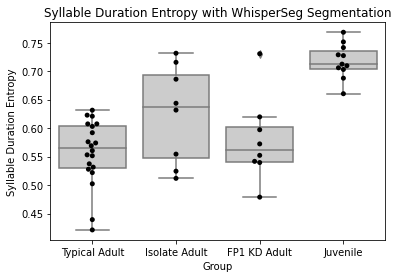

In [12]:
sns.boxplot(data = all_shan, x = 'Group', y = 'entropy_wseg', color = '0.8')
sns.swarmplot(data = all_shan, x = 'Group', y = 'entropy_wseg', color = 'black', s = 5)
plt.ylabel('Syllable Duration Entropy')
plt.title('Syllable Duration Entropy with WhisperSeg Segmentation')

In [7]:
isolates_AVN = all_shan.entropy_wseg[all_shan.Group== 'Isolate Adult']
normal_AVN = all_shan.entropy_wseg[all_shan.Group == 'Typical Adult']
FP1_AVN = all_shan.entropy_wseg[all_shan.Group == 'FP1 KD Adult']
juvenile_AVN = all_shan.entropy_wseg[all_shan.Group == 'Juvenile']

In [8]:
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [9]:
fvalue, pvalue = f_oneway(isolates_AVN, normal_AVN, FP1_AVN, juvenile_AVN)
print(fvalue, pvalue)

17.12865342497001 1.8240316289039386e-07


In [10]:
tukey = pairwise_tukeyhsd(endog = all_shan['entropy_wseg'], 
                          groups = all_shan['Group'], 
                          alpha = 0.05)

print(tukey)

       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1        group2    meandiff p-adj   lower   upper  reject
------------------------------------------------------------------
 FP1 KD Adult Isolate Adult   0.0458 0.4474 -0.0359  0.1276  False
 FP1 KD Adult      Juvenile   0.1388 0.0001  0.0628  0.2148   True
 FP1 KD Adult Typical Adult  -0.0215 0.8354 -0.0899  0.0469  False
Isolate Adult      Juvenile    0.093  0.011   0.017   0.169   True
Isolate Adult Typical Adult  -0.0673 0.0552 -0.1358  0.0011  False
     Juvenile Typical Adult  -0.1603    0.0 -0.2217 -0.0989   True
------------------------------------------------------------------


# Gaps

## Adult Bird Data

In [5]:
All_Birds = ["B145", "B236", "B258", "B385", "B402", "B447", 
             "B507", "G255", "G397", "G402", "G413", "G437", 
             "G439", "G524", "G528", "O144", "O254", "O421", 
             "O440", "O512", "R402", "R425", "R469", "S132", 
             "S421", "S525", "S528", "Y389", "Y397", "Y425", 
             "Y440", "B524", "O434", "S389", "Y433", "Y453"] 

#All_Birds should contain 36 bird IDs. Check: 
len(All_Birds)

36

In [6]:
bin_dur = 10

In [8]:
w_all_shan_gap = pd.DataFrame()
for Bird_ID in All_Birds:

    #load whisper-seg predictions
    segmentations_path = 'E:\\Final_Bird_Dataset\\WhisperSeg_Segmentation\\' + Bird_ID +  '_wseg.csv'
    predictions_wseg = pd.read_csv(segmentations_path)
    predictions_reformat = predictions_wseg.rename(columns = {'onset' : 'onsets', 
                                                'offset' : 'offsets',
                                                'file' : 'files'})

    predictions_reformat['labels'] = 's'
    
    song_folder_path = 'E:\\Final_Bird_Dataset\\FP1_project_birds\\segmented_songs\\' 

    syntax_data = syntax.SyntaxData(Bird_ID, predictions_reformat)
    syntax_data.add_file_bounds(song_folder_path)
    gaps_df = syntax_data.get_gaps_df()

    #select only gaps less than 200ms, as longer likely reflect inter-motif gaps
    gaps_df = gaps_df[gaps_df.durations < 0.2]
    #convert from s to ms
    gaps_df.durations = gaps_df.durations*1000

    bins = np.arange(0, 200, bin_dur)
    density, __ = np.histogram(gaps_df.durations, density=True, bins = bins)
    gap_entropy = entropy(density) / np.log(len(bins))

    curr_shan = pd.DataFrame({'wseg_gap_duration_entropy' : [gap_entropy],
                             "Bird_ID" : Bird_ID})
    
    w_all_shan_gap = pd.concat([w_all_shan_gap, curr_shan])

In [10]:
all_birds = pd.read_csv("E:\\Final_Bird_Dataset\\old_Bird_list.csv")
w_all_shan_gap = pd.merge(w_all_shan_gap, all_birds[['Bird_ID', 'Condition']], on = 'Bird_ID')

group_dict = {'Isolate' : 'Isolate Adult', 
              'GFP' : 'Typical Adult', 
              'FP1_KD_pre_tut' : 'FP1 KD Adult', 
              'FP1_KD_post_tut' : 'Typical Adult'}
w_all_shan_gap['Group'] = [group_dict[x] for x in w_all_shan_gap.Condition]

In [11]:
w_all_shan_gap.head(3)

,wseg_gap_duration_entropy,Bird_ID,Condition,Group
0,0.650696,B145,Isolate,Isolate Adult
1,0.890905,B236,Isolate,Isolate Adult
2,0.726944,B258,Isolate,Isolate Adult


## Juvenile Bird Data

In [12]:
all_birds = glob.glob('E:\\Juveniles\\Single_day_per_juvenile\\*')
all_birds = [x.split('\\')[-1] for x in all_birds]
all_birds

['Y855_51',
 'S856_51',
 'Y856_50',
 'S855_51',
 'S833_51',
 'O833_51',
 'notag833_51',
 'O883_51',
 'R833_51',
 'O472_50',
 'Y472_50']

In [13]:
len(all_birds)

11

In [14]:
juv_all_shan_gap = pd.DataFrame()
for Bird_ID in all_birds:

    #load wseg segmentations
    wseg_path = 'E:\\Juveniles\\WhisperSeg_segmentations\\' + Bird_ID +  '_wseg.csv'

    #load whisper-seg predictions
    segmentations_path = 'E:\\Final_Bird_Dataset\\WhisperSeg_Segmentation\\' + Bird_ID +  '_wseg.csv'
    predictions_wseg = pd.read_csv(wseg_path)
    predictions_reformat = predictions_wseg.rename(columns = {'onset' : 'onsets', 
                                                'offset' : 'offsets',
                                                'file' : 'files'})

    predictions_reformat['labels'] = 's'
    
    song_folder_path = 'E:\\Juveniles\\Single_day_per_juvenile\\'

    syntax_data = syntax.SyntaxData(Bird_ID, predictions_reformat)
    syntax_data.add_file_bounds(song_folder_path)
    gaps_df = syntax_data.get_gaps_df()

    #select only gaps less than 200ms, as longer likely reflect inter-motif gaps
    gaps_df = gaps_df[gaps_df.durations < 0.2]
    #convert from s to ms
    gaps_df.durations = gaps_df.durations*1000

    bins = np.arange(0, 200, bin_dur)
    density, __ = np.histogram(gaps_df.durations, density=True, bins = bins)
    gap_entropy = entropy(density) / np.log(len(bins))

    curr_shan = pd.DataFrame({'wseg_gap_duration_entropy' : [gap_entropy],
                             "Bird_ID" : Bird_ID})
    
    juv_all_shan_gap = pd.concat([juv_all_shan_gap, curr_shan])

In [16]:
juv_all_shan_gap['Group'] = 'Juvenile'

## Compare Groups

In [18]:
all_shan = pd.concat([w_all_shan_gap[['Bird_ID', 'Group', 'wseg_gap_duration_entropy']], juv_all_shan_gap])

In [20]:
all_shan.to_csv('gap_duration_entropies.csv')

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
all_shan = pd.read_csv('gap_duration_entropies.csv')

In [3]:
all_shan.head(3)

,Unnamed: 0,Bird_ID,Group,wseg_gap_duration_entropy
0,0,B145,Isolate Adult,0.650696
1,1,B236,Isolate Adult,0.890905
2,2,B258,Isolate Adult,0.726944


In [4]:
all_shan.Group = all_shan.Group.astype('category').cat.set_categories(['Typical Adult', 'Isolate Adult', 'FP1 KD Adult', 'Juvenile'], ordered = True)

Text(0.5, 1.0, 'Gap Duration Entropy with WhisperSeg Segmentation')

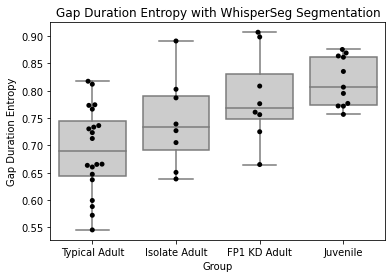

In [5]:
sns.boxplot(data = all_shan, x = 'Group', y = 'wseg_gap_duration_entropy', color = '0.8')
sns.swarmplot(data = all_shan, x = 'Group', y = 'wseg_gap_duration_entropy', color = 'black', s = 5)
plt.ylabel('Gap Duration Entropy')
plt.title('Gap Duration Entropy with WhisperSeg Segmentation')

In [6]:
isolates_AVN = all_shan.wseg_gap_duration_entropy[all_shan.Group== 'Isolate Adult']
normal_AVN = all_shan.wseg_gap_duration_entropy[all_shan.Group == 'Typical Adult']
FP1_AVN = all_shan.wseg_gap_duration_entropy[all_shan.Group == 'FP1 KD Adult']
juvenile_AVN = all_shan.wseg_gap_duration_entropy[all_shan.Group == 'Juvenile']

In [7]:
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [8]:
fvalue, pvalue = f_oneway(isolates_AVN, normal_AVN, FP1_AVN, juvenile_AVN)
print(fvalue, pvalue)

7.828253588616555 0.00028050094976418314


In [10]:
tukey = pairwise_tukeyhsd(endog = all_shan['wseg_gap_duration_entropy'], 
                          groups = all_shan['Group'], 
                          alpha = 0.05)

print(tukey)

       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1        group2    meandiff p-adj   lower   upper  reject
------------------------------------------------------------------
 FP1 KD Adult Isolate Adult  -0.0445  0.629 -0.1434  0.0544  False
 FP1 KD Adult      Juvenile   0.0296 0.8254 -0.0623  0.1215  False
 FP1 KD Adult Typical Adult  -0.0959 0.0174 -0.1787 -0.0132   True
Isolate Adult      Juvenile    0.074  0.153 -0.0179  0.1659  False
Isolate Adult Typical Adult  -0.0515  0.356 -0.1342  0.0313  False
     Juvenile Typical Adult  -0.1255 0.0003 -0.1997 -0.0512   True
------------------------------------------------------------------
